# **Deep Learning on Volumetric Representaion of 3D Objects**
This notebook implements the paper [VoxNet: A 3D Convolutional Neural Network for real-time object recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7353481).

## Getting started

In [ ]:
!pip install trimesh
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 646 kB 29.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import numpy as np
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from __future__ import print_function
import argparse
import random
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from trimesh.voxel import creation
import trimesh
from collections import OrderedDict
# def blue(x): return '\033[94m' + x + '\033[0m'

In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip #ModelNet10
!unzip -q ModelNet10.zip;

--2022-05-25 08:47:30--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  12.0MB/s    in 97s     

2022-05-25 08:49:07 (4.68 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [ ]:
!gdown https://drive.google.com/uc?id=1XidXoaltvr4l2oekrZM_eVFtz4DSQNFq #ModelNet10 Voxelized
!unzip -q ModelNet10_voxel.zip;

Downloading...
From: https://drive.google.com/uc?id=1XidXoaltvr4l2oekrZM_eVFtz4DSQNFq
To: /content/ModelNet10_voxel.zip
100% 3.11M/3.11M [00:00<00:00, 283MB/s]


In [ ]:
if torch.cuda.is_available():
  if_cuda=True
else:
  if_cuda=False
seed_value=0
np.random.seed(seed_value) # cpu vars
torch.manual_seed(seed_value) # cpu  vars
random.seed(seed_value) # Python
os.environ['PYTHONHASHSEED']=str(seed_value)
if if_cuda: 
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # gpu vars
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Voxelization of a sample mesh


In [ ]:
root = "./ModelNet10/"
class_name="chair"
file_name="chair_0001.off"
path=root+class_name+"/train/"+file_name

scene = trimesh.scene.Scene()
scene.add_geometry(trimesh.load(path))
scene.show()

In [ ]:
v = creation.voxelize(trimesh.load(path), pitch=7)
v.show()

We observe that as voxel size increases, we get more abstract geometry of the object. Thus, the origial geometry of the objects are not preserved.

## Voxelized ModelNet10 Dataset

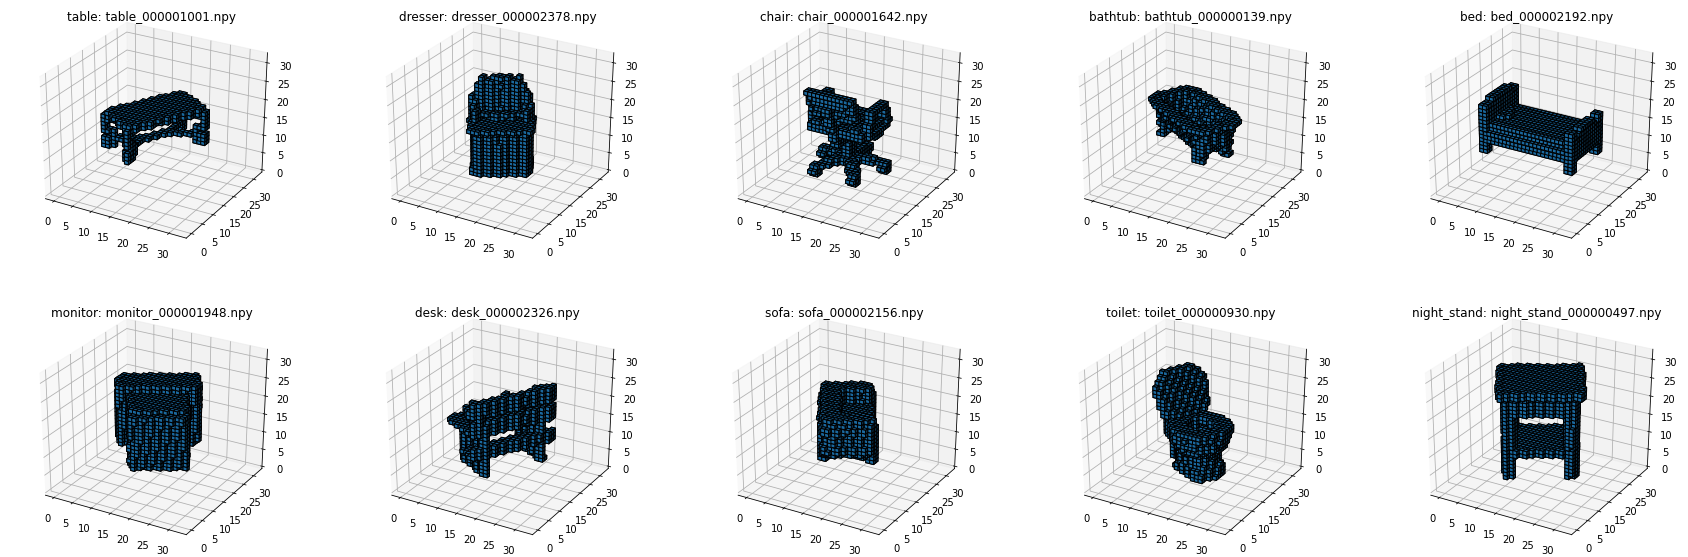

In [ ]:
root="ModelNet10_voxel/"
fig=plt.figure(figsize=(30,10))
for idx,cl in enumerate(os.listdir(root)):
  name = os.listdir(os.path.join(root,cl,"train"))[0]
  v_path = os.path.join(root,cl,"train", name)
  ax = fig.add_subplot(2, 5, idx+1, projection='3d')
  p = ax.voxels(np.load(v_path), edgecolor='k')
  ax.set_title(cl+": "+name)


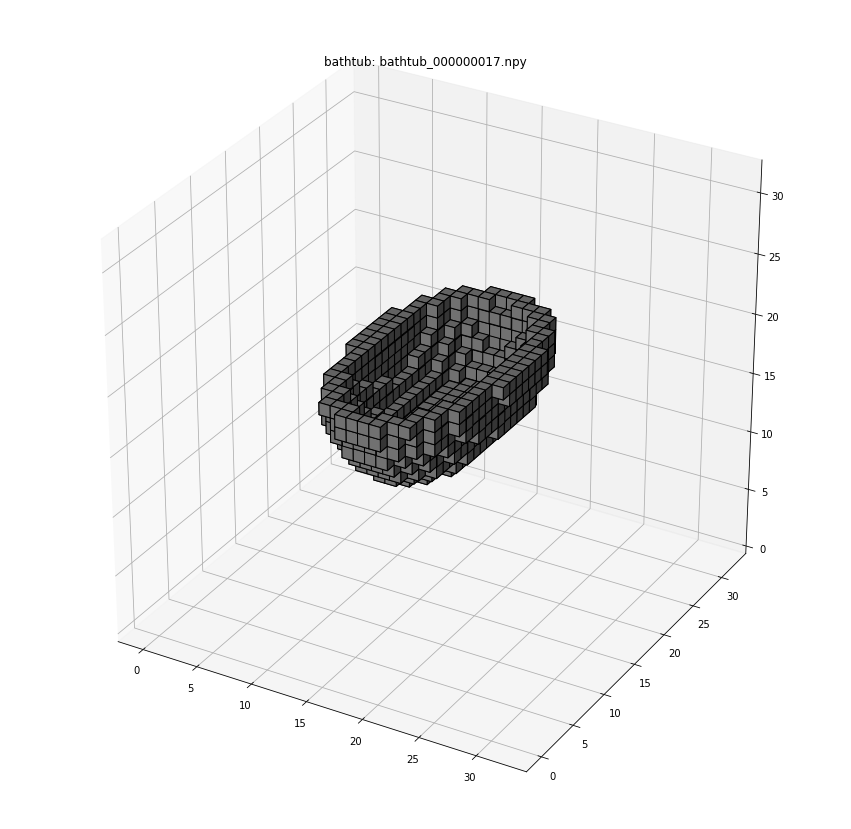

In [ ]:
class_name="bathtub"
file="bathtub_000000017.npy"
path=root+class_name+"/train/"

fig=plt.figure(figsize=(15,15))
ax=fig.gca(projection='3d')
ax.voxels(np.load(os.path.join(path,file)), edgecolor='k', facecolors='grey')
ax.set_title(class_name+": "+file)
plt.show()

## Voxelized ModelNet10 Dataloader

In [ ]:
class ModelNet10Voxel(Dataset):
    def __init__(self, data_root, n_classes, idx2cls, split='train'):
        """
        Args:
            split (str, optional): 'train' or 'test'. Defaults to 'train'.
        """
        self.data_root = data_root
        self.n_classes = n_classes
        self.samples_str = []
        self.cls2idx = {}
        for k, v in idx2cls.items():
            self.cls2idx.update({v: k})
            for sample_str in glob.glob(os.path.join(data_root, v, split, '*.npy')):
                self.samples_str.append(sample_str)

    def __getitem__(self, idx):
        sample_name = self.samples_str[idx]
        cls_name = sample_name.split("/")[-3]
        cls_idx = self.cls2idx[cls_name]
        data = np.load(sample_name)
        data = data[np.newaxis, :]
        sample = {'voxel': data, 'cls_idx': cls_idx}
        return sample

    def __len__(self):
        return len(self.samples_str)

In [ ]:
CLASSES = {
    0: 'bathtub',
    1: 'chair',
    2: 'dresser',
    3: 'night_stand',
    4: 'sofa',
    5: 'toilet',
    6: 'bed',
    7: 'desk',
    8: 'monitor',
    9: 'table'
}

data_root = './ModelNet10_voxel'
outf = './voxel_cls'
batchSize = 256
workers =2
epochs=30

In [ ]:
train_dataset = ModelNet10Voxel(data_root=data_root, n_classes=len(CLASSES), idx2cls=CLASSES, split='train')
test_dataset = ModelNet10Voxel(data_root=data_root, n_classes=len(CLASSES), idx2cls=CLASSES, split='test')

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 3991
Test dataset size: 908


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))
test_dataloader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False, num_workers=int(workers))

## VoxNet Model

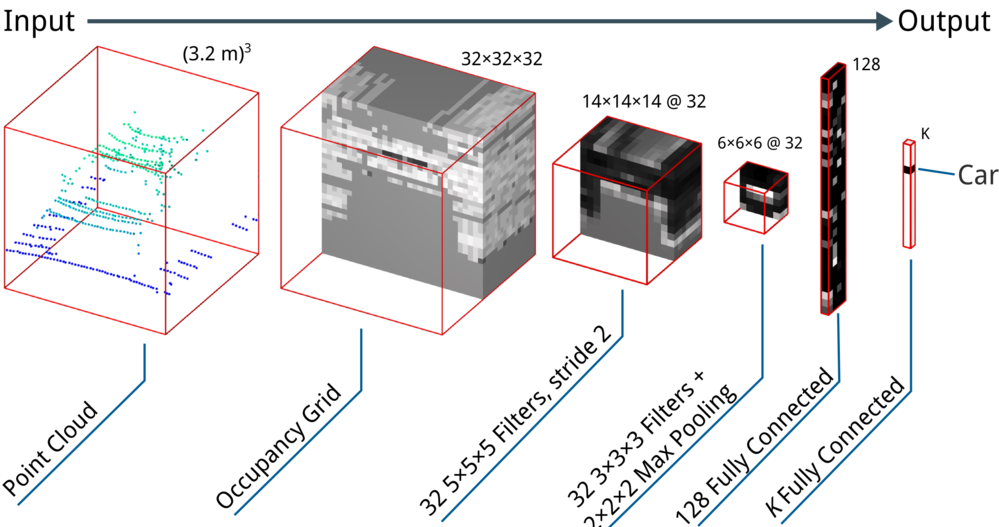

In [ ]:
class VoxNet(torch.nn.Module):
    def __init__(self, n_classes=10, input_shape=(32, 32, 32)):
        super(VoxNet, self).__init__()
        self.n_classes = n_classes
        self.input_shape = input_shape
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1,
                                         out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1

        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, self.n_classes))
        ]))

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x

In [ ]:
voxnet = VoxNet(n_classes=len(CLASSES)) #model instance
print(voxnet)
if torch.cuda.is_available():
  voxnet = voxnet.cuda()

optimizer = optim.Adam(voxnet.parameters(), lr=1e-4) #optimizer

VoxNet(
  (feat): Sequential(
    (conv3d_1): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2))
    (relu1): ReLU()
    (drop1): Dropout(p=0.2, inplace=False)
    (conv3d_2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (relu2): ReLU()
    (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2): Dropout(p=0.3, inplace=False)
  )
  (mlp): Sequential(
    (fc1): Linear(in_features=6912, out_features=128, bias=True)
    (relu1): ReLU()
    (drop3): Dropout(p=0.4, inplace=False)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Training Loop

In [ ]:
num_batch = len(train_dataset) // batchSize
best_acc=0
for epoch in range(epochs):
  mean_correct = []
  for i, sample in enumerate(train_dataloader):
    voxel, cls_idx = sample['voxel'], sample['cls_idx']
    if torch.cuda.is_available():
      voxel, cls_idx = voxel.cuda(), cls_idx.cuda()
    voxel = voxel.float()  #torch.Size([batch_size, 1, 32, 32, 32])
    
    optimizer.zero_grad()

    voxnet = voxnet.train()
    pred = voxnet(voxel)  #torch.Size([batch_size, 10])

    loss = F.cross_entropy(pred, cls_idx)
    
    loss.backward()
    optimizer.step()

    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(cls_idx.data).cpu().sum()
    mean_correct.append(correct.item() / float(batchSize))
  print('\n[%d/%d] train loss: %f mean accuracy: %f' %(epoch+1, epochs,loss.item(), np.mean(mean_correct)))
    
  with torch.no_grad():
    mean_correct=[]
    for j, sample in enumerate(test_dataloader):
      voxel, cls_idx = sample['voxel'], sample['cls_idx']
      if torch.cuda.is_available():
        voxel, cls_idx = voxel.cuda(), cls_idx.cuda()
      voxel = voxel.float()  #torch.Size([256, 1, 32, 32, 32])
      voxnet = voxnet.eval()
      pred = voxnet(voxel)
      loss = F.nll_loss(pred, cls_idx)
      pred_choice = pred.data.max(1)[1]
      correct = pred_choice.eq(cls_idx.data).cpu().sum()
      mean_correct.append(correct.item() / float(batchSize))
  acc = np.mean(mean_correct)
  print('test [%d], mean accuracy: %f' % (epoch+1, acc))
  
  if acc>=best_acc:
    if not os.path.isdir(outf):
      os.mkdir(outf)
    torch.save(voxnet.state_dict(), '%s/cls_model_%d.pth' % (outf, epoch+1))
    best_acc=acc



[1/30] train loss: 2.099577 mean accuracy: 0.230225
test [1], mean accuracy: 0.183594

[2/30] train loss: 1.568127 mean accuracy: 0.414795
test [2], mean accuracy: 0.371094

[3/30] train loss: 1.249194 mean accuracy: 0.548096
test [3], mean accuracy: 0.518555

[4/30] train loss: 1.036104 mean accuracy: 0.605469
test [4], mean accuracy: 0.575195

[5/30] train loss: 0.977291 mean accuracy: 0.653809
test [5], mean accuracy: 0.614258

[6/30] train loss: 0.769031 mean accuracy: 0.700195
test [6], mean accuracy: 0.648438

[7/30] train loss: 0.748701 mean accuracy: 0.710693
test [7], mean accuracy: 0.641602

[8/30] train loss: 0.788936 mean accuracy: 0.735107
test [8], mean accuracy: 0.659180

[9/30] train loss: 0.708813 mean accuracy: 0.734619
test [9], mean accuracy: 0.662109

[10/30] train loss: 0.681184 mean accuracy: 0.753418
test [10], mean accuracy: 0.680664

[11/30] train loss: 0.621455 mean accuracy: 0.770996
test [11], mean accuracy: 0.680664

[12/30] train loss: 0.748663 mean accu

## Evaluation on Test set

In [ ]:
!gdown https://drive.google.com/uc?id=1IPhxjzvG9XkRzOEaB3S-GiSB8Trud4ac

Downloading...
From: https://drive.google.com/uc?id=1IPhxjzvG9XkRzOEaB3S-GiSB8Trud4ac
To: /content/cls_model_30.pth
100% 3.67M/3.67M [00:00<00:00, 291MB/s]


In [ ]:
model_name="cls_model_30.pth"
voxnet.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
  mean_correct=[]
  for j, sample in enumerate(test_dataloader):
    voxel, cls_idx = sample['voxel'], sample['cls_idx']
    if torch.cuda.is_available():
      voxel, cls_idx = voxel.cuda(), cls_idx.cuda()
    voxel = voxel.float()  #torch.Size([256, 1, 32, 32, 32])
    voxnet = voxnet.eval()
    pred = voxnet(voxel)
    loss = F.nll_loss(pred, cls_idx)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(cls_idx.data).cpu().sum()
    all_preds += list(pred_choice.cpu().numpy())
    all_labels += list(cls_idx.cpu().numpy())
    mean_correct.append(correct.item() / float(batchSize))
acc = np.mean(mean_correct)
print('Test set classification accuracy: %f' % (acc))

Test set classification accuracy: 0.724609


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds);
cm

array([[30,  0,  0,  0,  8,  0,  8,  0,  0,  4],
       [ 0, 96,  0,  0,  0,  0,  1,  0,  2,  1],
       [ 0,  0, 67, 11,  1,  2,  0,  0,  5,  0],
       [ 0,  0, 23, 55,  0,  1,  0,  2,  1,  4],
       [ 0,  0,  1,  1, 94,  1,  3,  0,  0,  0],
       [ 0,  2,  0,  2,  0, 94,  0,  0,  2,  0],
       [ 2,  1,  0,  0,  5,  0, 91,  0,  0,  1],
       [ 0,  3,  1,  6,  5,  1,  5, 52,  0, 13],
       [ 0,  4,  3,  1,  0,  0,  0,  0, 92,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 28,  0, 71]])

In [ ]:
import itertools
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


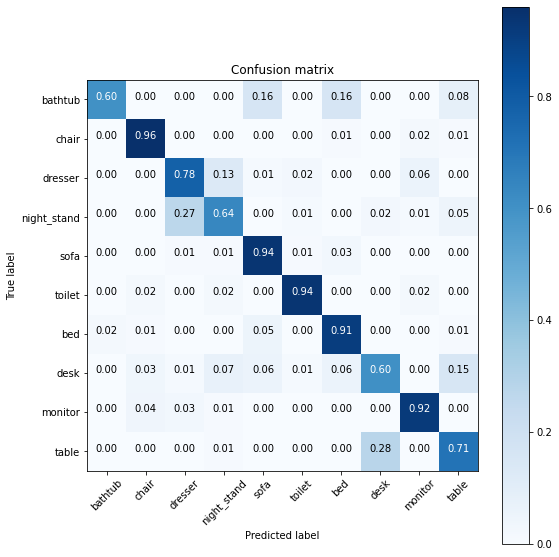

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(CLASSES.values()), normalize=True)

Confusion matrix, without normalization


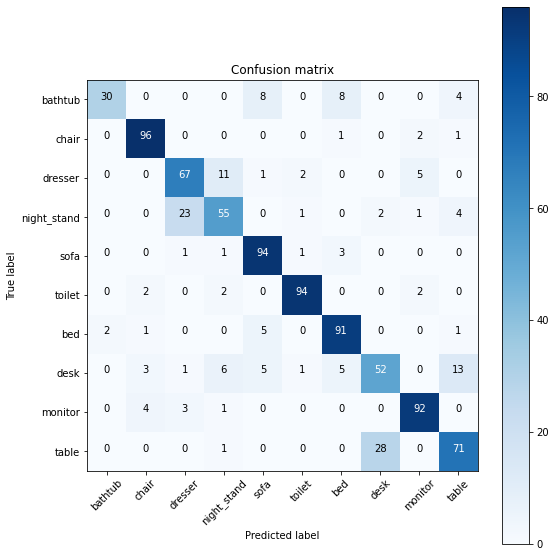

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(CLASSES.values()), normalize=False)